# Flight Delay Prediction

**Target:** `ARRIVAL_DELAY > 15 min` (Binary Classification)

## 1. Data Loading

In [68]:
"""
Data Loading

Load the flight data and supporting reference tables for airlines and airports.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Data source path
DATA_PATH = "Data Source/"

# Load datasets
print("Loading datasets...")
df_flights = pd.read_csv(DATA_PATH + "flights.csv", low_memory=False)
df_airlines = pd.read_csv(DATA_PATH + "airlines.csv")
df_airports = pd.read_csv(DATA_PATH + "airports.csv")

# Create lookup dictionaries for airline and airport names
airline_names = dict(zip(df_airlines['IATA_CODE'], df_airlines['AIRLINE']))
airport_names = dict(zip(df_airports['IATA_CODE'], df_airports['AIRPORT']))

# Display dataset info
print(f"Flights:  {df_flights.shape[0]:,} rows x {df_flights.shape[1]} columns")
print(f"Airlines: {len(airline_names)} carriers")
print(f"Airports: {len(airport_names)} locations")

Loading datasets...
Flights:  5,819,079 rows x 31 columns
Airlines: 14 carriers
Airports: 322 locations


## 2. Exploratory Data Analysis

### 2.1 Target Variable

TARGET VARIABLE: ARRIVAL_DELAY
Delayed (>15 min):  1,023,498 (17.6%)
On-Time (<=15 min): 4,690,510 (80.6%)
Missing:            105,071 (1.8%)

Class Imbalance: 4.58:1


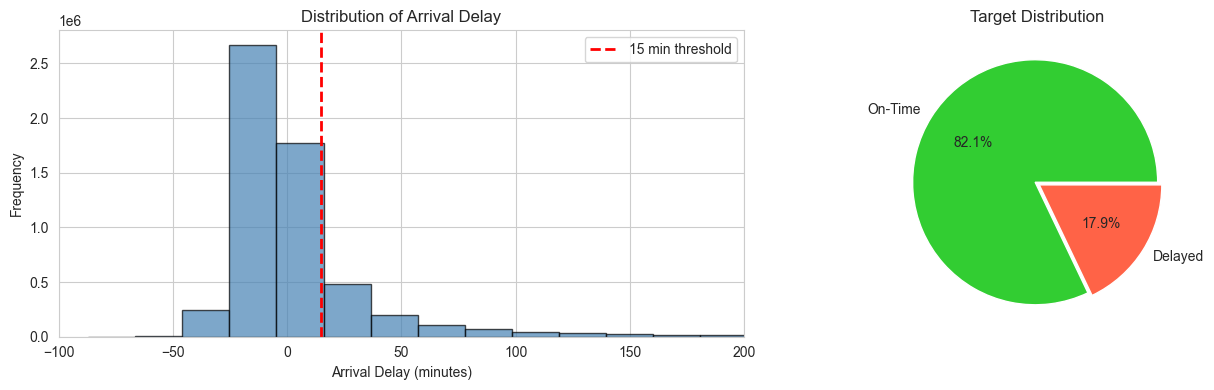

In [69]:
"""
Target Variable Analysis

Analyze the distribution of arrival delays and create the binary classification target.
Delayed flights are defined as those with ARRIVAL_DELAY > 15 minutes.
"""

delayed_count = (df_flights['ARRIVAL_DELAY'] > 15).sum()
on_time_count = (df_flights['ARRIVAL_DELAY'] <= 15).sum()
missing_count = df_flights['ARRIVAL_DELAY'].isna().sum()
total = len(df_flights)

print("TARGET VARIABLE: ARRIVAL_DELAY")
print("=" * 50)
print(f"Delayed (>15 min):  {delayed_count:,} ({delayed_count / total * 100:.1f}%)")
print(f"On-Time (<=15 min): {on_time_count:,} ({on_time_count / total * 100:.1f}%)")
print(f"Missing:            {missing_count:,} ({missing_count / total * 100:.1f}%)")
print(f"\nClass Imbalance: {on_time_count / delayed_count:.2f}:1")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Histogram of arrival delay distribution
axes[0].hist(
    df_flights['ARRIVAL_DELAY'].dropna(),
    bins=100,
    color='steelblue',
    edgecolor='black',
    alpha=0.7
)
axes[0].axvline(x=15, color='red', linestyle='--', linewidth=2, label='15 min threshold')
axes[0].set_xlabel('Arrival Delay (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Arrival Delay')
axes[0].set_xlim(-100, 200)
axes[0].legend()

# Pie chart of target distribution
axes[1].pie(
    [on_time_count, delayed_count],
    labels=['On-Time', 'Delayed'],
    autopct='%1.1f%%',
    colors=['limegreen', 'tomato'],
    explode=(0.02, 0.02)
)
axes[1].set_title('Target Distribution')

plt.tight_layout()
plt.show()

### 2.2 Feature Distributions

/var/folders/8p/9n3v5s6j0f5cyh586ndpswqh0000gn/T/ipykernel_82157/1087807656.py:65: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  delay_rates = df_flights.groupby('AIRLINE').apply(


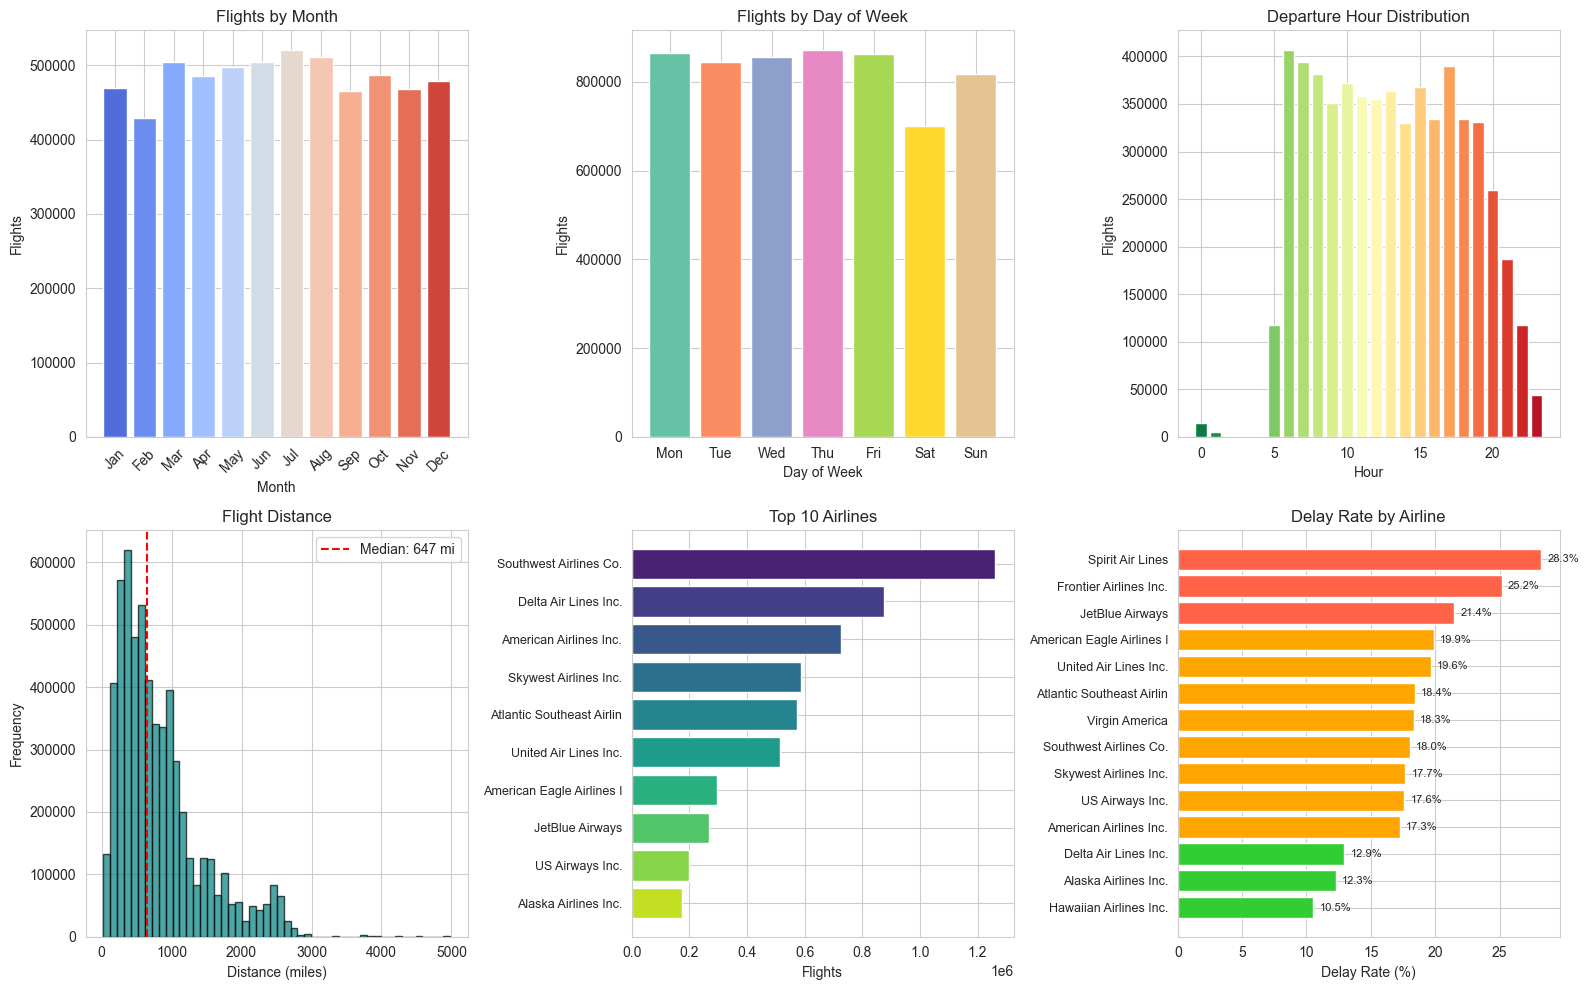

In [70]:
"""
Feature Distributions

Visualize the distribution of key features including temporal patterns,
flight distance, and airline-level statistics.
"""

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Flights by Month
month_counts = df_flights['MONTH'].value_counts().sort_index()
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 0].bar(month_counts.index, month_counts.values,
               color=sns.color_palette("coolwarm", 12))
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Flights')
axes[0, 0].set_title('Flights by Month')
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].set_xticklabels(month_labels, rotation=45)

# Flights by Day of Week
dow_counts = df_flights['DAY_OF_WEEK'].value_counts().sort_index()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(dow_counts.index, dow_counts.values,
               color=sns.color_palette("Set2", 7))
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Flights')
axes[0, 1].set_title('Flights by Day of Week')
axes[0, 1].set_xticks(range(1, 8))
axes[0, 1].set_xticklabels(dow_labels)

# Departure Hour Distribution
dep_hour = df_flights['SCHEDULED_DEPARTURE'] // 100
hour_counts = dep_hour.value_counts().sort_index()
axes[0, 2].bar(hour_counts.index, hour_counts.values,
               color=sns.color_palette("RdYlGn_r", 24))
axes[0, 2].set_xlabel('Hour')
axes[0, 2].set_ylabel('Flights')
axes[0, 2].set_title('Departure Hour Distribution')

# Flight Distance Distribution
axes[1, 0].hist(df_flights['DISTANCE'], bins=50, color='teal',
                edgecolor='black', alpha=0.7)
median_distance = df_flights["DISTANCE"].median()
axes[1, 0].axvline(median_distance, color='red', linestyle='--',
                   label=f'Median: {median_distance:.0f} mi')
axes[1, 0].set_xlabel('Distance (miles)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Flight Distance')
axes[1, 0].legend()

# Top 10 Airlines by Flight Count
airline_counts = df_flights['AIRLINE'].value_counts().head(10)
airline_labels = [airline_names.get(c, c)[:25] for c in airline_counts.index]
axes[1, 1].barh(range(len(airline_labels)), airline_counts.values,
                color=sns.color_palette("viridis", 10))
axes[1, 1].set_yticks(range(len(airline_labels)))
axes[1, 1].set_yticklabels(airline_labels, fontsize=9)
axes[1, 1].set_xlabel('Flights')
axes[1, 1].set_title('Top 10 Airlines')
axes[1, 1].invert_yaxis()

# Delay Rate by Airline
delay_rates = df_flights.groupby('AIRLINE').apply(
    lambda x: (x['ARRIVAL_DELAY'] > 15).mean() * 100
).sort_values(ascending=False)
delay_labels = [airline_names.get(c, c)[:25] for c in delay_rates.index]

# Color code by delay severity: red (>20%), orange (>15%), green (<=15%)
colors = []
for rate in delay_rates.values:
    if rate > 20:
        colors.append('tomato')
    elif rate > 15:
        colors.append('orange')
    else:
        colors.append('limegreen')

axes[1, 2].barh(range(len(delay_labels)), delay_rates.values, color=colors)
axes[1, 2].set_yticks(range(len(delay_labels)))
axes[1, 2].set_yticklabels(delay_labels, fontsize=9)
axes[1, 2].set_xlabel('Delay Rate (%)')
axes[1, 2].set_title('Delay Rate by Airline')
axes[1, 2].invert_yaxis()

for i, rate in enumerate(delay_rates.values):
    axes[1, 2].text(rate + 0.5, i, f'{rate:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.show()

### 2.3 Delay Patterns by Time

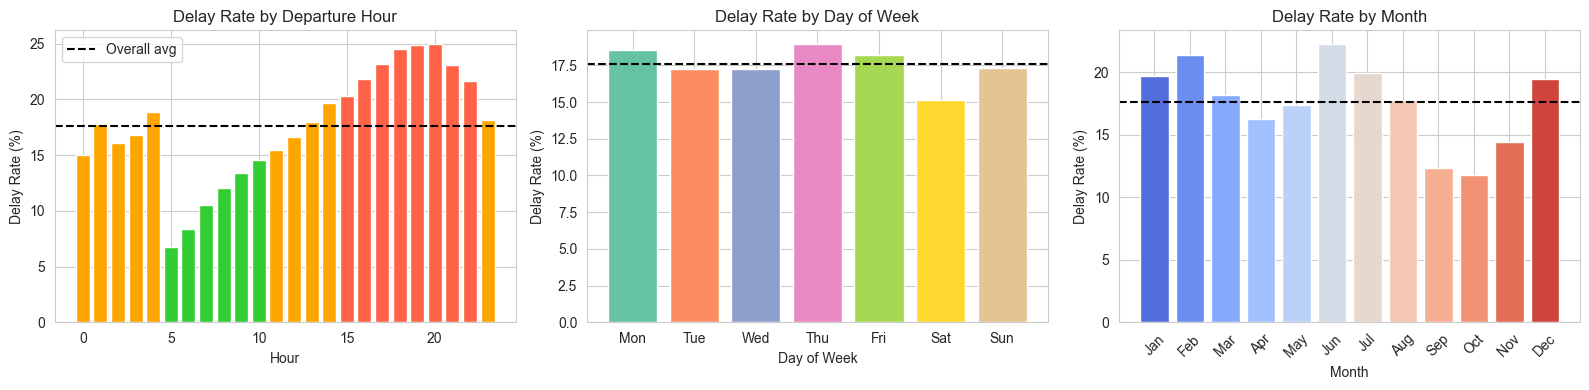

In [71]:
"""
Delay Patterns by Time

Analyze how delay rates vary by departure hour, day of week, and month.
"""

# Create temporary columns for analysis
df_flights['DEP_HOUR'] = df_flights['SCHEDULED_DEPARTURE'] // 100
df_flights['IS_DELAYED'] = (df_flights['ARRIVAL_DELAY'] > 15).astype(int)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Delay rate by hour
hourly_delay = df_flights.groupby('DEP_HOUR')['IS_DELAYED'].mean() * 100

# Color code by delay severity
colors = []
for rate in hourly_delay.values:
    if rate > 20:
        colors.append('tomato')
    elif rate > 15:
        colors.append('orange')
    else:
        colors.append('limegreen')

axes[0].bar(hourly_delay.index, hourly_delay.values, color=colors)
overall_delay_rate = df_flights['IS_DELAYED'].mean() * 100
axes[0].axhline(y=overall_delay_rate, color='black', linestyle='--', label='Overall avg')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Delay Rate (%)')
axes[0].set_title('Delay Rate by Departure Hour')
axes[0].legend()

# Delay rate by day of week
dow_delay = df_flights.groupby('DAY_OF_WEEK')['IS_DELAYED'].mean() * 100
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1].bar(dow_delay.index, dow_delay.values, color=sns.color_palette("Set2", 7))
axes[1].axhline(y=overall_delay_rate, color='black', linestyle='--')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Delay Rate (%)')
axes[1].set_title('Delay Rate by Day of Week')
axes[1].set_xticks(range(1, 8))
axes[1].set_xticklabels(dow_labels)

# Delay rate by month
monthly_delay = df_flights.groupby('MONTH')['IS_DELAYED'].mean() * 100
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[2].bar(monthly_delay.index, monthly_delay.values,
            color=sns.color_palette("coolwarm", 12))
axes[2].axhline(y=overall_delay_rate, color='black', linestyle='--')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Delay Rate (%)')
axes[2].set_title('Delay Rate by Month')
axes[2].set_xticks(range(1, 13))
axes[2].set_xticklabels(month_labels, rotation=45)

plt.tight_layout()
plt.show()

# Clean up temporary columns
df_flights.drop(['DEP_HOUR', 'IS_DELAYED'], axis=1, inplace=True)

## 3. Data Preprocessing

In [72]:
"""
Data Preprocessing

Clean the data by removing cancelled/diverted flights, handling missing values,
and selecting relevant features for modeling.
"""

print(f"Original: {len(df_flights):,} rows")

# Remove cancelled and diverted flights
df = df_flights[
    (df_flights['CANCELLED'] == 0) & (df_flights['DIVERTED'] == 0)
].copy()
print(f"After removing cancelled/diverted: {len(df):,} rows")

# Remove rows with missing values in key columns
df = df[df['ARRIVAL_DELAY'].notna() & df['SCHEDULED_TIME'].notna()]
print(f"After removing missing values: {len(df):,} rows")

# Select columns for modeling
cols = [
    'MONTH', 'DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
    'SCHEDULED_DEPARTURE', 'SCHEDULED_TIME', 'DISTANCE', 'ARRIVAL_DELAY'
]
df = df[cols].copy()

# Create binary target variable (delayed if arrival delay > 15 minutes)
df['DELAYED'] = (df['ARRIVAL_DELAY'] > 15).astype(int)
df.drop('ARRIVAL_DELAY', axis=1, inplace=True)

print(f"\nFinal dataset: {len(df):,} rows x {df.shape[1]} columns")
print(f"Delay rate: {df['DELAYED'].mean() * 100:.2f}%")

Original: 5,819,079 rows
After removing cancelled/diverted: 5,714,008 rows
After removing missing values: 5,714,008 rows

Final dataset: 5,714,008 rows x 9 columns
Delay rate: 17.91%


## 4. Train/Validation/Test/Production Split

Split the data into four sets:
- **Training**: ~40% - Used to train the model
- **Validation**: ~10% - Used for hyperparameter tuning and early stopping
- **Test**: ~10% - Used for final model evaluation
- **Production**: ~40% - Reserved for production simulation

In [73]:
"""
Split data into training, validation, test, and production sets.

Split ratios:
- Training: 40%
- Validation: 10%
- Test: 10%
- Production: 40%
"""

from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
RANDOM_STATE = 42

# First split: separate production data (40%) from modeling data (60%)
modeling_df, prod_df = train_test_split(
    df,
    test_size=0.40,
    random_state=RANDOM_STATE,
    stratify=df['DELAYED']
)

# Second split: from modeling data, get train (40/60 = 66.7%) and temp (20/60 = 33.3%)
train_df, temp_df = train_test_split(
    modeling_df,
    test_size=0.333,
    random_state=RANDOM_STATE,
    stratify=modeling_df['DELAYED']
)

# Third split: from temp, get validation (50%) and test (50%)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=RANDOM_STATE,
    stratify=temp_df['DELAYED']
)

# Display dataset sizes and delay rates
print("Dataset Sizes:")
print("=" * 60)

total_rows = len(df)
datasets = [
    ('Training', train_df),
    ('Validation', val_df),
    ('Test', test_df),
    ('Production', prod_df)
]

for name, data in datasets:
    n_rows = len(data)
    pct = n_rows / total_rows * 100
    delay_rate = data['DELAYED'].mean() * 100
    print(f"{name:12}: {n_rows:>10,} rows ({pct:5.1f}%) | Delay rate: {delay_rate:.2f}%")

Dataset Sizes:
Training    :  2,286,745 rows ( 40.0%) | Delay rate: 17.91%
Validation  :    570,829 rows ( 10.0%) | Delay rate: 17.91%
Test        :    570,830 rows ( 10.0%) | Delay rate: 17.91%
Production  :  2,285,604 rows ( 40.0%) | Delay rate: 17.91%


## 5. Feature Engineering

In [74]:
"""
Feature Engineering

Create features for flight delay prediction including:
- Temporal features (hour, cyclical encoding, peak hours)
- Distance-based features
- Target-encoded categorical features with Bayesian smoothing
- Volume-based features (airport/route popularity)
"""


def engineer_features(train, val, test, prod):
    """
    Create features for flight delay prediction.
    
    All aggregate statistics are computed from training data only to prevent
    data leakage.
    
    Parameters
    ----------
    train : pd.DataFrame
        Training dataset
    val : pd.DataFrame
        Validation dataset
    test : pd.DataFrame
        Test dataset
    prod : pd.DataFrame
        Production dataset
        
    Returns
    -------
    tuple
        Modified (train, val, test, prod) DataFrames with engineered features
    """
    
    all_datasets = [train, val, test, prod]
    
    # --- Row-level features ---
    for data in all_datasets:
        # Departure hour from scheduled departure time
        data['DEP_HOUR'] = data['SCHEDULED_DEPARTURE'] // 100
        
        # Cyclical encoding for hour (captures daily patterns)
        data['HOUR_SIN'] = np.sin(2 * np.pi * data['DEP_HOUR'] / 24)
        data['HOUR_COS'] = np.cos(2 * np.pi * data['DEP_HOUR'] / 24)
        
        # Peak hours: morning rush (6-9) and evening rush (16-20)
        is_morning_rush = (data['DEP_HOUR'] >= 6) & (data['DEP_HOUR'] <= 9)
        is_evening_rush = (data['DEP_HOUR'] >= 16) & (data['DEP_HOUR'] <= 20)
        data['IS_PEAK_HOUR'] = (is_morning_rush | is_evening_rush).astype(int)
        
        # Late night flights (after 9pm)
        data['IS_LATE_NIGHT'] = (data['DEP_HOUR'] >= 21).astype(int)
        
        # Weekend indicator
        data['IS_WEEKEND'] = (data['DAY_OF_WEEK'] >= 6).astype(int)
        
        # Flight speed (miles per minute)
        data['SPEED'] = data['DISTANCE'] / data['SCHEDULED_TIME'].replace(0, np.nan)
        data['SPEED'] = data['SPEED'].fillna(data['SPEED'].median())
        
        # Long haul flight indicator (> 1500 miles)
        data['IS_LONG_HAUL'] = (data['DISTANCE'] > 1500).astype(int)
        
        # Drop raw scheduled departure (replaced by DEP_HOUR)
        data.drop('SCHEDULED_DEPARTURE', axis=1, inplace=True)
    
    # --- Smoothed target encoding ---
    # Using Bayesian mean to prevent overfitting on rare categories
    global_delay_rate = train['DELAYED'].mean()
    smoothing = 100  # Smoothing factor
    
    def smoothed_target_encode(train_data, col, target='DELAYED'):
        """
        Calculate smoothed delay rate for a categorical column.
        
        Uses Bayesian average to handle rare categories:
        smoothed_rate = (sum + smoothing * global_mean) / (count + smoothing)
        """
        stats = train_data.groupby(col)[target].agg(['sum', 'count'])
        stats['smoothed_rate'] = (
            (stats['sum'] + smoothing * global_delay_rate) / 
            (stats['count'] + smoothing)
        )
        return stats['smoothed_rate'].to_dict()
    
    # Airline delay rate (smoothed)
    airline_delay = smoothed_target_encode(train, 'AIRLINE')
    for data in all_datasets:
        data['AIRLINE_DELAY_RATE'] = (
            data['AIRLINE'].map(airline_delay).fillna(global_delay_rate)
        )
    
    # Origin airport delay rate (smoothed)
    origin_delay = smoothed_target_encode(train, 'ORIGIN_AIRPORT')
    for data in all_datasets:
        data['ORIGIN_DELAY_RATE'] = (
            data['ORIGIN_AIRPORT'].map(origin_delay).fillna(global_delay_rate)
        )
    
    # Destination airport delay rate (smoothed)
    dest_delay = smoothed_target_encode(train, 'DESTINATION_AIRPORT')
    for data in all_datasets:
        data['DEST_DELAY_RATE'] = (
            data['DESTINATION_AIRPORT'].map(dest_delay).fillna(global_delay_rate)
        )
    
    # Route delay rate (smoothed)
    for data in all_datasets:
        data['ROUTE'] = data['ORIGIN_AIRPORT'] + '_' + data['DESTINATION_AIRPORT']
    
    route_delay = smoothed_target_encode(train, 'ROUTE')
    for data in all_datasets:
        data['ROUTE_DELAY_RATE'] = (
            data['ROUTE'].map(route_delay).fillna(global_delay_rate)
        )
    
    # --- Volume-based features ---
    # Airport busyness (log-scaled flight counts)
    origin_counts = train['ORIGIN_AIRPORT'].value_counts().to_dict()
    dest_counts = train['DESTINATION_AIRPORT'].value_counts().to_dict()
    
    for data in all_datasets:
        data['ORIGIN_FLIGHTS'] = np.log1p(
            data['ORIGIN_AIRPORT'].map(origin_counts).fillna(0)
        )
        data['DEST_FLIGHTS'] = np.log1p(
            data['DESTINATION_AIRPORT'].map(dest_counts).fillna(0)
        )
    
    # Route popularity (log-scaled)
    route_counts = train['ROUTE'].value_counts().to_dict()
    for data in all_datasets:
        data['ROUTE_FLIGHTS'] = np.log1p(
            data['ROUTE'].map(route_counts).fillna(0)
        )
    
    # --- Hourly delay patterns ---
    hourly_delay = smoothed_target_encode(train, 'DEP_HOUR')
    for data in all_datasets:
        data['HOUR_DELAY_RATE'] = (
            data['DEP_HOUR'].map(hourly_delay).fillna(global_delay_rate)
        )
    
    # --- Drop categorical columns (replaced by encoded features) ---
    drop_cols = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ROUTE']
    for data in all_datasets:
        data.drop(columns=drop_cols, inplace=True)
    
    return train, val, test, prod


print("Engineering features...")
train_df, val_df, test_df, prod_df = engineer_features(
    train_df, val_df, test_df, prod_df
)
print(f"Features created: {train_df.shape[1] - 1}")

Engineering features...
Features created: 20


## 6. Prepare Feature Matrices

In [75]:
"""
Prepare Feature Matrices

Separate features (X) and target (y) for all datasets.
"""

# Training set
X_train = train_df.drop('DELAYED', axis=1)
y_train = train_df['DELAYED']

# Validation set
X_val = val_df.drop('DELAYED', axis=1)
y_val = val_df['DELAYED']

# Test set
X_test = test_df.drop('DELAYED', axis=1)
y_test = test_df['DELAYED']

# Production set
X_prod = prod_df.drop('DELAYED', axis=1)
y_prod = prod_df['DELAYED']

# Display shapes
print("Feature Matrix Shapes:")
print("=" * 60)
print(f"Training:   X={X_train.shape}, y={y_train.shape}")
print(f"Validation: X={X_val.shape}, y={y_val.shape}")
print(f"Test:       X={X_test.shape}, y={y_test.shape}")
print(f"Production: X={X_prod.shape}, y={y_prod.shape}")

# Display feature list
print("\nFeature List:")
for i, col in enumerate(X_train.columns, 1):
    print(f"{i:2}. {col}")

# Display class balance
print(f"\nClass Balance (Training):")
print(f"On-Time: {(y_train == 0).sum():,} ({(y_train == 0).mean() * 100:.1f}%)")
print(f"Delayed: {(y_train == 1).sum():,} ({(y_train == 1).mean() * 100:.1f}%)")

Feature Matrix Shapes:
Training:   X=(2286745, 20), y=(2286745,)
Validation: X=(570829, 20), y=(570829,)
Test:       X=(570830, 20), y=(570830,)
Production: X=(2285604, 20), y=(2285604,)

Feature List:
 1. MONTH
 2. DAY_OF_WEEK
 3. SCHEDULED_TIME
 4. DISTANCE
 5. DEP_HOUR
 6. HOUR_SIN
 7. HOUR_COS
 8. IS_PEAK_HOUR
 9. IS_LATE_NIGHT
10. IS_WEEKEND
11. SPEED
12. IS_LONG_HAUL
13. AIRLINE_DELAY_RATE
14. ORIGIN_DELAY_RATE
15. DEST_DELAY_RATE
16. ROUTE_DELAY_RATE
17. ORIGIN_FLIGHTS
18. DEST_FLIGHTS
19. ROUTE_FLIGHTS
20. HOUR_DELAY_RATE

Class Balance (Training):
On-Time: 1,877,141 (82.1%)
Delayed: 409,604 (17.9%)


## 7. XGBoost Model Training

In [76]:
"""
XGBoost Model Training

Train a gradient boosted tree classifier with class weighting to handle
imbalanced data. Uses early stopping based on validation AUC.
"""

import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    precision_recall_curve
)
import time

# Calculate class weight (capped to prevent extreme predictions)
pos_weight = min((y_train == 0).sum() / (y_train == 1).sum(), 3.0)
print(f"scale_pos_weight: {pos_weight:.2f} (capped at 3.0)")

# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=pos_weight,
    max_depth=6,
    learning_rate=0.03,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    gamma=0.3,
    reg_alpha=0.1,
    reg_lambda=2.0,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

# Train the model
print("\nTraining XGBoost...")
start = time.time()

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

elapsed = time.time() - start
print(f"\nTraining completed in {elapsed:.1f}s")
print(f"Best iteration: {model.best_iteration}")
print(f"Best validation AUC: {model.best_score:.4f}")

scale_pos_weight: 3.00 (capped at 3.0)

Training XGBoost...
[0]	validation_0-auc:0.63913
[100]	validation_0-auc:0.66771
[200]	validation_0-auc:0.67552
[300]	validation_0-auc:0.67994
[400]	validation_0-auc:0.68271
[500]	validation_0-auc:0.68491
[600]	validation_0-auc:0.68674
[700]	validation_0-auc:0.68824
[800]	validation_0-auc:0.68943
[900]	validation_0-auc:0.69042
[999]	validation_0-auc:0.69133

Training completed in 90.7s
Best iteration: 999
Best validation AUC: 0.6913


## 8. Threshold Optimization

Find the optimal probability threshold to maximize F1 score.

Optimal threshold: 0.412
At this threshold:
  Precision: 0.2832
  Recall:    0.6161
  F1:        0.3881


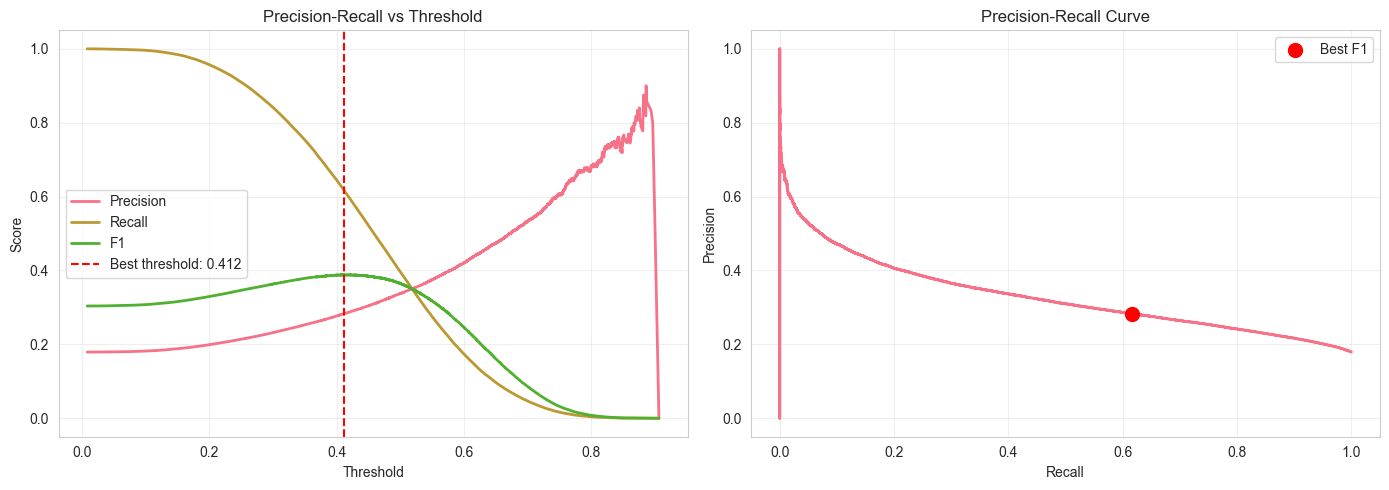

In [77]:
"""
Threshold Optimization

Find the optimal probability threshold to maximize F1 score on the
validation set using the precision-recall curve.
"""

# Get predicted probabilities on validation set
val_probs = model.predict_proba(X_val)[:, 1]

# Calculate precision and recall at various thresholds
precision_arr, recall_arr, thresholds = precision_recall_curve(y_val, val_probs)

# Calculate F1 for each threshold
f1_scores = (
    2 * (precision_arr[:-1] * recall_arr[:-1]) /
    (precision_arr[:-1] + recall_arr[:-1] + 1e-8)
)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

# Display optimal threshold metrics
print(f"Optimal threshold: {best_threshold:.3f}")
print(f"At this threshold:")
print(f"  Precision: {precision_arr[best_idx]:.4f}")
print(f"  Recall:    {recall_arr[best_idx]:.4f}")
print(f"  F1:        {f1_scores[best_idx]:.4f}")

# Plot threshold analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Precision, Recall, F1 vs Threshold
axes[0].plot(thresholds, precision_arr[:-1], label='Precision', linewidth=2)
axes[0].plot(thresholds, recall_arr[:-1], label='Recall', linewidth=2)
axes[0].plot(thresholds, f1_scores, label='F1', linewidth=2)
axes[0].axvline(
    x=best_threshold, color='red', linestyle='--',
    label=f'Best threshold: {best_threshold:.3f}'
)
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Precision-Recall vs Threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
axes[1].plot(recall_arr, precision_arr, linewidth=2)
axes[1].scatter(
    [recall_arr[best_idx]], [precision_arr[best_idx]],
    color='red', s=100, zorder=5, label='Best F1'
)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Model Evaluation

In [78]:
"""
Model Evaluation

Evaluate model performance on training, validation, test, and production sets
using the optimized probability threshold.
"""


def evaluate(model, X, y, name, threshold=0.5):
    """
    Evaluate model performance on a dataset.
    
    Parameters
    ----------
    model : XGBClassifier
        Trained model
    X : pd.DataFrame
        Feature matrix
    y : pd.Series
        True labels
    name : str
        Dataset name for display
    threshold : float
        Probability threshold for classification
        
    Returns
    -------
    dict
        Dictionary of evaluation metrics
    """
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)
    
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, zero_division=0)
    rec = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    auc = roc_auc_score(y, y_prob)
    
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n{'=' * 60}")
    print(f"{name} (threshold={threshold:.3f})")
    print(f"{'=' * 60}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"  TN: {tn:>8,}  |  FP: {fp:>8,}")
    print(f"  FN: {fn:>8,}  |  TP: {tp:>8,}")
    
    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'auc': auc
    }


print("Model Performance with Optimized Threshold")
print("=" * 60)

train_metrics = evaluate(model, X_train, y_train, "TRAINING", threshold=best_threshold)
val_metrics = evaluate(model, X_val, y_val, "VALIDATION", threshold=best_threshold)
test_metrics = evaluate(model, X_test, y_test, "TEST", threshold=best_threshold)
prod_metrics = evaluate(model, X_prod, y_prod, "PRODUCTION", threshold=best_threshold)

Model Performance with Optimized Threshold

TRAINING (threshold=0.412)
Accuracy:  0.6570
Precision: 0.2902
Recall:    0.6325
F1-Score:  0.3979
AUC:       0.7050

Confusion Matrix:
  TN: 1,243,404  |  FP:  633,737
  FN:  150,518  |  TP:  259,086

VALIDATION (threshold=0.412)
Accuracy:  0.6519
Precision: 0.2832
Recall:    0.6161
F1-Score:  0.3881
AUC:       0.6913

Confusion Matrix:
  TN:  309,151  |  FP:  159,431
  FN:   39,252  |  TP:   62,995

TEST (threshold=0.412)
Accuracy:  0.6515
Precision: 0.2828
Recall:    0.6159
F1-Score:  0.3876
AUC:       0.6907

Confusion Matrix:
  TN:  308,895  |  FP:  159,687
  FN:   39,273  |  TP:   62,975

PRODUCTION (threshold=0.412)
Accuracy:  0.6506
Precision: 0.2822
Recall:    0.6159
F1-Score:  0.3871
AUC:       0.6900

Confusion Matrix:
  TN: 1,234,866  |  FP:  641,339
  FN:  157,248  |  TP:  252,151


## 10. Feature Importance

Feature Importance:
 1. HOUR_DELAY_RATE           0.2964
 2. ROUTE_DELAY_RATE          0.1647
 3. HOUR_SIN                  0.1075
 4. AIRLINE_DELAY_RATE        0.0573
 5. DEP_HOUR                  0.0505
 6. MONTH                     0.0476
 7. ORIGIN_DELAY_RATE         0.0303
 8. DAY_OF_WEEK               0.0293
 9. ROUTE_FLIGHTS             0.0287
10. IS_WEEKEND                0.0239
11. DEST_DELAY_RATE           0.0237
12. ORIGIN_FLIGHTS            0.0231
13. DEST_FLIGHTS              0.0226
14. IS_LATE_NIGHT             0.0166
15. IS_LONG_HAUL              0.0144
16. HOUR_COS                  0.0142
17. DISTANCE                  0.0131
18. SPEED                     0.0130
19. IS_PEAK_HOUR              0.0128
20. SCHEDULED_TIME            0.0104


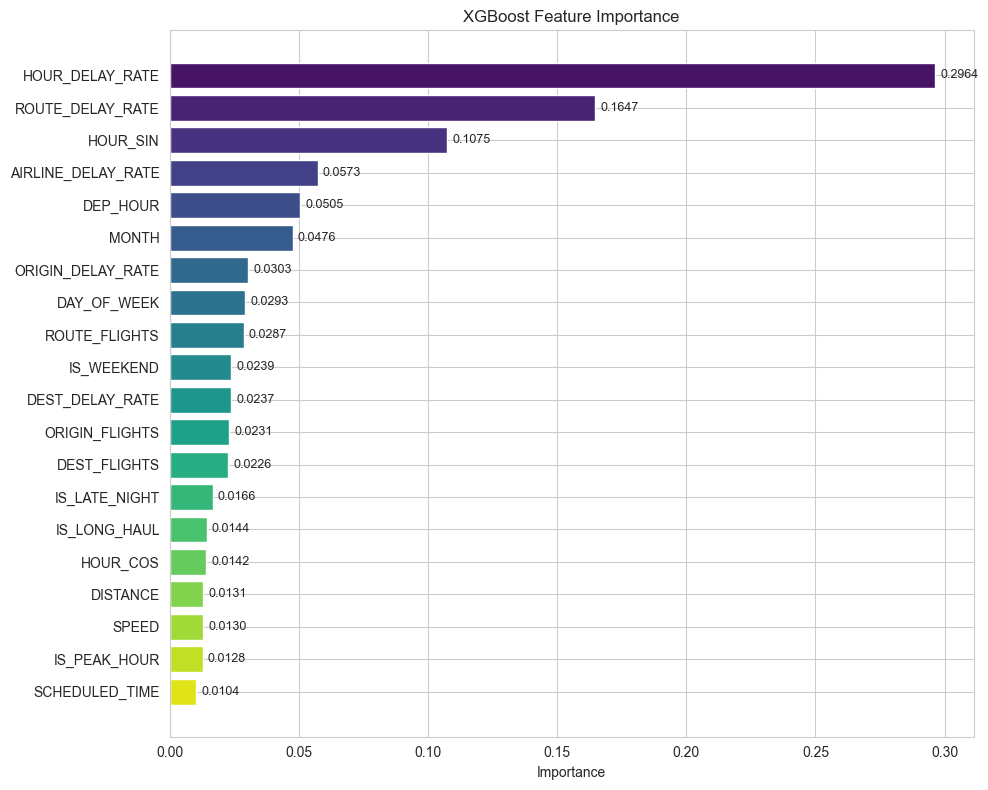

In [79]:
"""
Feature Importance

Analyze which features contribute most to the model's predictions.
"""

# Create importance DataFrame
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Display feature importance
print("Feature Importance:")
print("=" * 50)
for i, (_, row) in enumerate(importance_df.iterrows(), 1):
    print(f"{i:2}. {row['Feature']:25} {row['Importance']:.4f}")

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))

colors = sns.color_palette("viridis", len(importance_df))
ax.barh(range(len(importance_df)), importance_df['Importance'].values, color=colors)
ax.set_yticks(range(len(importance_df)))
ax.set_yticklabels(importance_df['Feature'].values)
ax.set_xlabel('Importance')
ax.set_title('XGBoost Feature Importance')
ax.invert_yaxis()

# Add value labels
for i, imp in enumerate(importance_df['Importance'].values):
    ax.text(imp + 0.002, i, f'{imp:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 11. Summary

In [80]:
"""
Final Summary

Summary of dataset sizes, model configuration, and performance metrics.
"""

print("=" * 60)
print("FINAL MODEL SUMMARY")
print("=" * 60)

print(f"\nDataset:")
print(f"  Training samples:   {len(X_train):,} (~40%)")
print(f"  Validation samples: {len(X_val):,} (~10%)")
print(f"  Test samples:       {len(X_test):,} (~10%)")
print(f"  Production samples: {len(X_prod):,} (~40%)")
print(f"  Features:           {X_train.shape[1]}")

print(f"\nModel Configuration:")
print(f"  Best iteration:     {model.best_iteration}")
print(f"  Optimal threshold:  {best_threshold:.3f}")

print(f"\nTest Set Performance:")
print(f"  AUC:       {test_metrics['auc']:.4f}")
print(f"  F1-Score:  {test_metrics['f1']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")

print(f"\nProduction Set Performance:")
print(f"  AUC:       {prod_metrics['auc']:.4f}")
print(f"  F1-Score:  {prod_metrics['f1']:.4f}")
print(f"  Precision: {prod_metrics['precision']:.4f}")
print(f"  Recall:    {prod_metrics['recall']:.4f}")
print(f"  Accuracy:  {prod_metrics['accuracy']:.4f}")

print(f"\nTop 5 Features:")
for i, (_, row) in enumerate(importance_df.head(5).iterrows(), 1):
    print(f"  {i}. {row['Feature']}: {row['Importance']:.4f}")

print("\n" + "=" * 60)

FINAL MODEL SUMMARY

Dataset:
  Training samples:   2,286,745 (~40%)
  Validation samples: 570,829 (~10%)
  Test samples:       570,830 (~10%)
  Production samples: 2,285,604 (~40%)
  Features:           20

Model Configuration:
  Best iteration:     999
  Optimal threshold:  0.412

Test Set Performance:
  AUC:       0.6907
  F1-Score:  0.3876
  Precision: 0.2828
  Recall:    0.6159
  Accuracy:  0.6515

Production Set Performance:
  AUC:       0.6900
  F1-Score:  0.3871
  Precision: 0.2822
  Recall:    0.6159
  Accuracy:  0.6506

Top 5 Features:
  1. HOUR_DELAY_RATE: 0.2964
  2. ROUTE_DELAY_RATE: 0.1647
  3. HOUR_SIN: 0.1075
  4. AIRLINE_DELAY_RATE: 0.0573
  5. DEP_HOUR: 0.0505

